# Cross-correlation procedure in three steps

In [1]:
# Importing all libraries
import numpy
from time import time
from matplotlib import pyplot
from codes.prism import prism_tf
from codes.grids import regular_grid
from codes.plot import draw_prism
from codes.auxiliars import addnoise
from codes.statistical import analysis, cccoef
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv
from codes.equivalentlayer import layer, rtp_layer

In [2]:
# Defines number of points and area
nx, ny = 40, 40
area = (-2000., 2000., -2000., 2000.)
shape = (nx, ny)
xo, yo, zo = regular_grid(area, shape, -100.)

### First step - Synthetic model

In [3]:
# Define the dike models
dike = [-560., 540., -800., 650., 100., 900., 1.275]
# Directions
inc, dec = 10., -5. # field
incs, decs = 6., -7. # source

In [4]:
# Computes the total field anomaly
tf = prism_tf(xo, yo, zo, dike, inc, dec, incs, decs)

In [5]:
# Analyze the data
_ = analysis(tf, 'nT')

Minimum:    -264.1656 nT
Maximum:    135.8233 nT
Mean value: -11.3446 nT
Variation:  399.9890 nT


In [6]:
# Adding noise
tf = addnoise(tf, 5., 0.1)

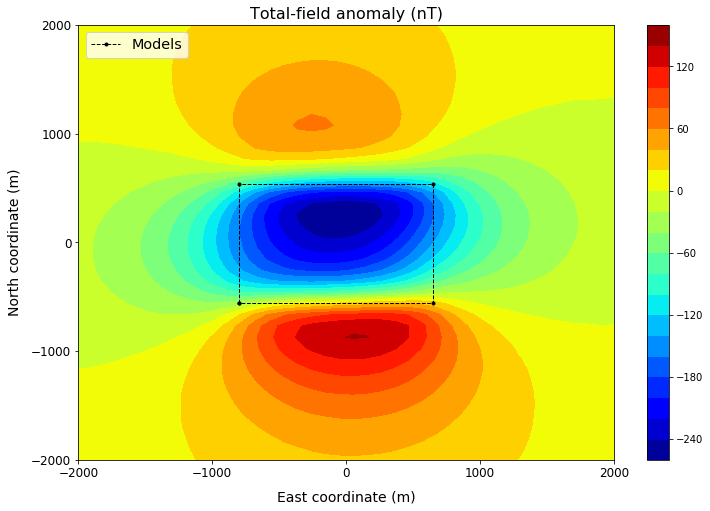

In [7]:
# Plotting the result
pyplot.figure(figsize=(12, 8))
pyplot.contourf(yo.reshape(shape), xo.reshape(shape), tf.reshape(shape), 
                20, cmap = pyplot.cm.jet)
# Draw the model edges
draw_prism(dike[:4], linewidth=1., style = 'k.--' , label = 'Models', xy2ne = True)
pyplot.title('Total-field anomaly (nT)', fontsize = 16)
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
pyplot.legend(loc = 'upper left', fontsize = 'x-large')

#pyplot.savefig('fig01-totalfieldanomaly.png', dpi = 300, bbox_inches = 'tight')
pyplot.show()

In [8]:
# Layer informations
area_layer = (-2000., 2000., -2000., 2000.)
shape_layer = (15, 15)
level = 800.

In [9]:
# Create the layer
eqlayer = layer(area_layer, shape_layer, level)

In [10]:
# Allocate all values as a list
data = [xo, yo, zo, tf]

### Second step - Cross correlation

In [82]:
# Create the grid
inclination = numpy.linspace(-90., 90., 19)
declination = numpy.linspace(-180., 180., 25)
D, I = numpy.meshgrid(declination, inclination)

In [83]:
print 'Inclination values:', inclination
print 'Declination values:', declination

Inclination values: [-90. -80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.  50.
  60.  70.  80.  90.]
Declination values: [-180. -165. -150. -135. -120. -105.  -90.  -75.  -60.  -45.  -30.  -15.
    0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.  165.
  180.]


In [84]:
# Create the zero matrix
res = numpy.zeros_like(D)

In [85]:
# Reshaping the files
xobs = xo.reshape(shape)
yobs = yo.reshape(shape)
tf = tf.reshape(shape)

In [ ]:
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination):
        if i >= -20. or i <= 20.:
            rtp = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, i, d)
            tga = totalgrad(xobs, yobs, rtp)
            vga = zderiv(xobs, yobs, rtp)        
            res[k1,k2] = cccoef(tga, vga)
        else:
            rtp = reduction(xobs, yobs, tf, inc, dec, i, d)
            tga = totalgrad(xobs, yobs, rtp)
            vga = zderiv(xobs, yobs, rtp)
            res[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Computation time (sec): %.3f' % (final-initial)

In [79]:
# Analysing the positive coefficients
print 'Simple correlation (positive):'
_ = analysis(res, 'no unit')

Simple correlation (positive):
Minimum:    -0.6277 no unit
Maximum:    0.6277 no unit
Mean value: -0.0091 no unit
Variation:  1.2554 no unit


In [80]:
# Search for the maximum and minimum pair of inclination and declination
imax, jmax = numpy.where(res == res.max())
imin, jmin = numpy.where(res == res.min())
incmax = float(I[imax, jmax])
decmax = float(D[imax, jmax])
incmin = float(I[imin, jmin])
decmin = float(D[imin, jmin])
print 'Verify the computed correlation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax
print 'Declination:', decmax
#print
#print '(I,D) for minimum coefficient:'
#print 'Inclination:', incmin
#print 'Declination:', decmin

Verify the computed correlation:
(I,D) for maximum coefficient
Inclination: 12.0
Declination: 0.0


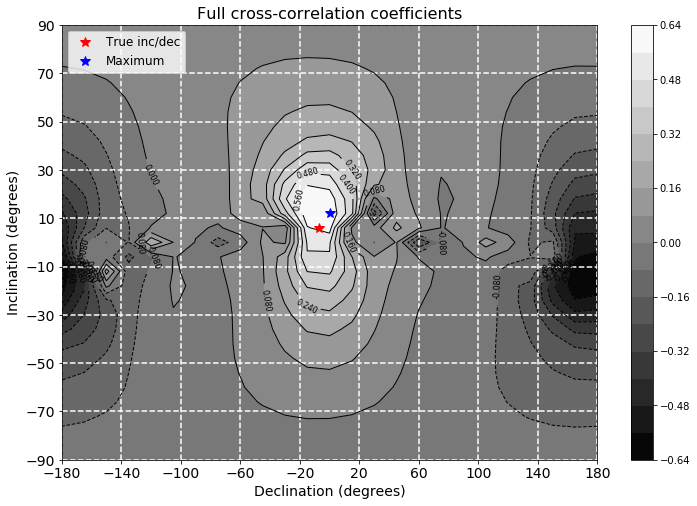

In [81]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 8))
fig1 = pyplot.contour(D, I, res, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D, I, res, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig1, fontsize = 8)
#pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.plot(decs, incs, 'r*', label = 'True inc/dec', markersize = 10)
pyplot.plot(decmax, incmax, 'b*', label = 'Maximum', markersize = 10)
#pyplot.plot(decmin, incmin, 'y*', label = 'Minimum', markersize = 10)
pyplot.title('Full cross-correlation coefficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D.min(), D.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I.min(), I.max(), 10), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')
pyplot.colorbar()
pyplot.grid(color='w', linestyle='--', linewidth = 1.5)
pyplot.show()

In [43]:
newres = res[int(imax)-2:int(imax)+3, int(jmax)-2:int(jmax)+3]
newdec = D[int(imax)-2:int(imax)+3, int(jmax)-2:int(jmax)+3]
newinc = I[int(imax)-2:int(imax)+3, int(jmax)-2:int(jmax)+3]

In [44]:
# Define the new max/min values
vxmin, vxmax = newdec.min(), newdec.max()
vymin, vymax = newinc.min(), newinc.max()
#vcolor = numpy.linspace(0., res.max(), 5)

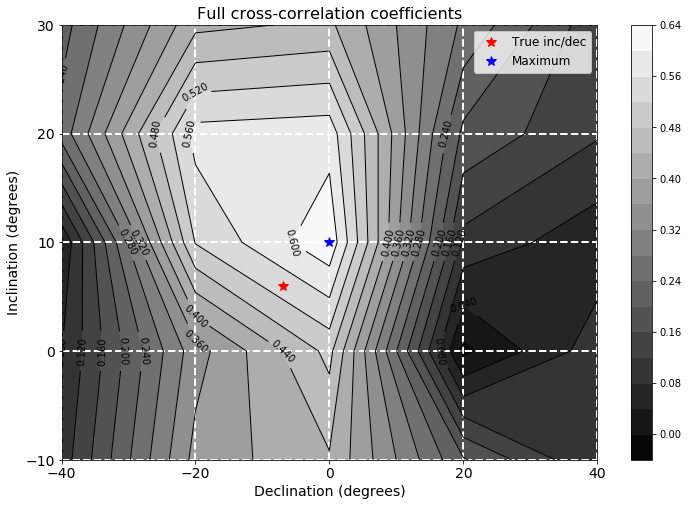

In [45]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 8))
fig2 = pyplot.contour(newdec, newinc, newres, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(newdec, newinc, newres, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig2, fontsize = 10)
pyplot.plot(decs, incs, 'r*', label = 'True inc/dec', markersize = 10)
pyplot.plot(decmax, incmax, 'b*', label = 'Maximum', markersize = 10)
pyplot.title('Full cross-correlation coefficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(newdec.min(), newdec.max(), 5), fontsize = 14)
pyplot.yticks(numpy.linspace(newinc.min(), newinc.max(), 5), fontsize = 14)
pyplot.xlim(newdec.min(), newdec.max())
pyplot.ylim(newinc.min(), newinc.max())
pyplot.legend(loc = 'upper right', fontsize = 'large')
cb = pyplot.colorbar()
pyplot.grid(color='w', linestyle='--', linewidth=2)
pyplot.show()

### Third step - Inversion problem

In [ ]:
# Data reshape of all observed data, inclination and declination
dobs = newres.reshape(newres.size)
dinc = newinc.reshape(newinc.size)
ddec = newdec.reshape(newdec.size)

In [ ]:
# Size of Jacobian matrix
num = dobs.size

In [ ]:
# Define the steps for derivation
deltainc = 0.01*(dinc.max() - dinc.min())
deltadec = 0.005*(ddec.max() - ddec.min())

In [ ]:
print 'Step of incliantion values:', deltainc
print 'Step of decliantion values:', deltadec

In [ ]:
# Initial values
p0 = numpy.array([incmax, decmax])

In [ ]:
# Create the zero Jacobian matrix
mat = numpy.zeros((num,2))
# Define the tolerance
tolerance = 0.00005
# Number of iterations
itmax = 30
# Zero order Tikhonov
regulator = 0.00002

In [ ]:
rtp1 = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, p0[0], p0[1])
print cccoef(totalgrad(xobs, yobs, rtp1.reshape(shape)),
             zderiv(xobs, yobs, rtp1.reshape(shape)))
print cccoef(totalgrad(xobs, yobs, (rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, incs, decs)).reshape(shape)),
             zderiv(xobs, yobs, (rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, incs, decs)).reshape(shape)))

In [ ]:
print 'Residuo inicial: %.5f' % misfit

In [ ]:
for it in range(itmax):
    rtp1 = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, p0[0], p0[1])
    misfit_i = cccoef(totalgrad(xobs, yobs, rtp1.reshape(shape)),
                      zderiv(xobs, yobs, rtp1.reshape(shape)))
    for kdec, d in enumerate(ddec):
        # Calculate the negative variation at inclination
        rtp1_dinc = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, p0[0] - deltainc, d)
        cc1_dinc = cccoef(totalgrad(xobs, yobs, rtp1_dinc.reshape(shape)), 
                          zderiv(xobs, yobs, rtp1_dinc.reshape(shape)))
        # Calculate the positive variation at inclination
        rtp2_dinc = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, p0[0] + deltainc, d)
        cc2_dinc = cccoef(totalgrad(xobs, yobs, rtp2_dinc.reshape(shape)),
                          zderiv(xobs, yobs, rtp2_dinc.reshape(shape)))
        mat[kdec,0] = (cc2_dinc - cc1_dinc)/(2.*deltainc)
    for kinc, i in enumerate(dinc):
        # Calculate the negative variation at declination
        rtp1_ddec = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, i, p0[1] - deltadec)
        cc1_ddec = cccoef(totalgrad(xobs, yobs, rtp1_ddec.reshape(shape)), 
                      zderiv(xobs, yobs, rtp1_ddec.reshape(shape)))
        # Calculate the positive variation at inclination
        rtp2_ddec = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, i, p0[1] + deltadec)
        cc2_ddec = cccoef(totalgrad(xobs, yobs, rtp2_ddec.reshape(shape)), 
                      zderiv(xobs, yobs, rtp2_ddec.reshape(shape)))
        mat[kinc,1] = (cc2_ddec - cc1_ddec)/(2.*deltadec)
        
        # Calculation of P e updating for next iteration
        p = p0 + numpy.linalg.solve(numpy.dot(mat.T, mat) + regulator*numpy.identity(2),
                               numpy.dot(mat.T, dobs))
        
        # Calculate the new missfit
        rtp_newp = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, p[0], p[1])
        misfit_f = cccoef(totalgrad(xobs, yobs, rtp_newp.reshape(shape)),
                          zderiv(xobs, yobs, rtp_newp.reshape(shape)))
        
        #print 'Iteracao: / Inclination: %.2f / Declination: %.2f' % (it, p[0], p[1])
       
        # Stop criteria
        if abs(misfit_f - misfit_i) <= tolerance:
            print 'We have finished this, sucker!'
            break
        else:
            p0 = p

In [ ]:
# Calculation of P e updating for next iteration
p =  numpy.linalg.solve(numpy.dot(mat.T, mat) + toz*numpy.identity(2), 
                            numpy.dot(mat.T, dobs))

In [ ]:
print p0
print p

In [ ]:
# Calculate the new missfit
rtp_mf = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, p[0], p[1])
mft.append(cccoef(totalgrad(xobs, yobs, rtp_mf.reshape(shape)),
                  zderiv(xobs, yobs, rtp_mf.reshape(shape))))

In [ ]:
# Differences
diff.append(numpy.abs(mft[1] - mft[0]))